# Simplified Balance Ball Game - Search Algorithm Implementation

## Introduction
In this notebook, we explore various search algorithms to navigate a ball through a grid-based environment in the Simplified Balance Ball Game. Our objective is to tilt the platform to guide the ball to collect points efficiently and reach a goal state.

Now, let's set up our game environment and define the grid. We will also include a visualization function to help us see the state of the game at each step.


In [74]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from queue import Queue, PriorityQueue

In [75]:
# EMPTY cells are free to move into, POINT cells represent collectible points,
# BALL represents the current position of the ball, and OBSTACLE represents areas the ball cannot pass through.
# Global Definitions and Constants
EMPTY, POINT, BALL, OBSTACLE = 0, 1, 2, 3
SIZE = 5  # example for a 5x5 grid
# Define movement directions
directions = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}
goals = {(2, 2), (4, 4)}

def create_grid(size, points):
    grid = np.full((size, size), EMPTY)
    for point in points:
        grid[point] = POINT
    return grid

def plot_grid(grid, ball_position):
    fig, ax = plt.subplots()
    ax.matshow(grid, cmap=plt.cm.Blues)

    # Plot ball
    ax.plot(ball_position[1], ball_position[0], 'o', color='red')

    # Draw gridlines
    for i in range(SIZE):
        ax.axhline(i - 0.5, lw=2, color='k', zorder=5)
        ax.axvline(i - 0.5, lw=2, color='k', zorder=5)
    
    plt.xticks(range(SIZE))
    plt.yticks(range(SIZE))
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    plt.show()

The `create_grid` function initializes the grid with the given points, and the `plot_grid` function is responsible for drawing the grid and the ball's current position. Below, we visualize the initial state of our game board.

In [76]:
def plot_grid_with_path(grid, start, path, goals):
    grid_with_path = np.copy(grid)
    current_position = start
    for step in path:
        direction = directions[step]
        current_position = tuple(map(sum, zip(current_position, direction)))
        x, y = current_position
        grid_with_path[x, y] = BALL  # Mark the ball's path
    
    # Add remaining points
    for goal in goals:
        x, y = goal
        if grid_with_path[x, y] == EMPTY:
            grid_with_path[x, y] = POINT

    plot_grid(grid_with_path, current_position)

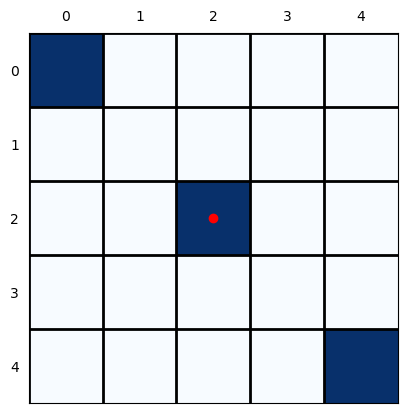

In [77]:
# Example
# Initialize the game grid with points
points = [(0, 0), (2, 2), (4, 4)]  # Define points in the grid
grid = create_grid(SIZE, points)  # Create the grid

# Visualize the initial grid state
plot_grid(grid, (2, 2))  # Visualize the grid with the ball's starting position

Next, we define the mechanics of our game. The `move_ball` function computes the ball's next position based on the direction of the tilt. The `tilt_platform` function simulates tilting the platform in one direction until the ball either hits an obstacle, collects a point, or can no longer move in that direction.

In [78]:
def is_valid(grid, position):
    # Check if a position is within the bounds and not an obstacle
    x, y = position
    return 0 <= x < SIZE and 0 <= y < SIZE and grid[x][y] != OBSTACLE

def move_ball(grid, start, direction, goals):
    # Calculate the next position
    x, y = start
    dx, dy = directions[direction]
    next_position = (x + dx, y + dy)
    
    # Check if the next position is valid
    if is_valid(grid, next_position):
        # If the next position has a point, return it as a goal state
        if next_position in goals:
            return next_position, True
        return next_position, False
    return start, False

def tilt_platform(grid, start, direction, goals):
    current_position = start
    collected_goals = set()
    while True:
        next_position, reached_goal = move_ball(grid, current_position, direction, goals)
        if reached_goal:
            collected_goals.add(next_position)
            # Check if all points are collected
            if collected_goals == goals:
                return next_position, collected_goals
        if current_position == next_position:
            break  # Ball has stopped moving
        current_position = next_position
    return current_position, collected_goals

def is_valid_move(grid, position, visited):
    x, y = position
    return (0 <= x < SIZE and 0 <= y < SIZE and grid[x, y] != OBSTACLE and position not in visited)

## Implementing Breadth-First Search (BFS)
BFS is a level-by-level search strategy. In the context of our game, it simulates the tilting of the platform in every direction possible, one step at a time, to find the shortest path to collect all the points.

Path found by BFS: ['down', 'up', 'down', 'down', 'right', 'right', 'down', 'down', 'right', 'right']
Collected goals by BFS: {(4, 4), (2, 2), (0, 0)}


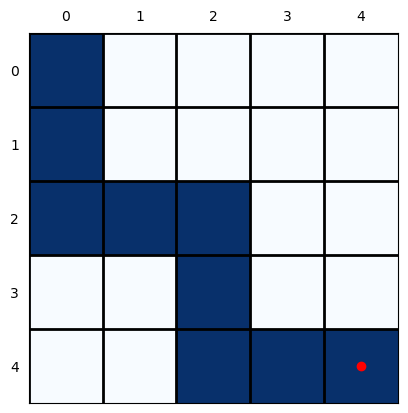

BFS path is valid and includes all goals.


In [79]:
# This is our implementation of the BFS algorithm tailored to our game's rules.
# We use a queue to keep track of the next positions to explore and a set to remember the positions we have visited.
def bfs(grid, start, goals):
    queue = Queue()
    queue.put((start, [], set()))
    visited = set()
    visited.add((start, frozenset()))

    while not queue.empty():
        current, path, collected_goals = queue.get()
        
        if collected_goals == goals:
            return path, collected_goals

        for direction, (dx, dy) in directions.items():
            next_position = (current[0] + dx, current[1] + dy)
            next_collected_goals = collected_goals | ({next_position} if next_position in goals else set())
            state = (next_position, frozenset(next_collected_goals))
            if is_valid(grid, next_position) and state not in visited:
                visited.add(state)
                queue.put((next_position, path + [direction], next_collected_goals))
    return None, None

# Run BFS to find a path
start = (0, 0)  # Define the ball's starting position
goals = set([(0, 0), (2, 2), (4, 4)])  # Define goal points

# Visualize the path found by BFS
path_bfs, collected_goals_bfs = bfs(grid, start, goals.copy())
if path_bfs:
    print("Path found by BFS:", path_bfs)
    print("Collected goals by BFS:", collected_goals_bfs)
    plot_grid_with_path(grid, start, path_bfs, goals)
else:
    print("No path found by BFS")

# Check the correctness of the BFS path
if path_bfs:
    # Reconstruct the path from directions to positions
    current_position = start
    collected_goals = set()
    for direction in path_bfs:
        current_position = tuple(map(sum, zip(current_position, directions[direction])))
        if current_position in goals:
            collected_goals.add(current_position)
    if collected_goals == goals:
        print("BFS path is valid and includes all goals.")
    else:
        print("BFS path is invalid; it does not include all goals.")

Path found by DLS: ['down', 'down', 'down', 'right', 'up', 'right', 'down', 'down', 'right', 'right']


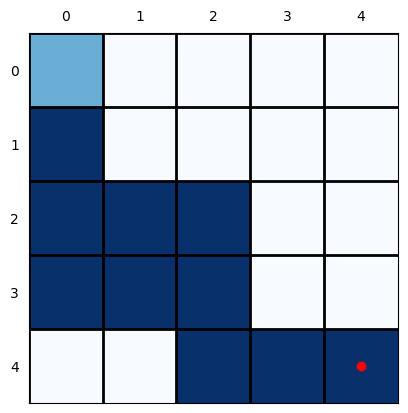

DLS path is valid and includes all goals.


In [80]:
def dls(grid, current, goals, path, visited, limit):
    # If all goals are collected, return the path
    if set(goals).issubset(visited):
        return path

    # If the limit is reached, return None
    if limit == 0:
        return None

    for direction, (dx, dy) in directions.items():
        next_position = (current[0] + dx, current[1] + dy)

        # Check if the move is valid and the state hasn't been visited.
        if is_valid(grid, next_position) and next_position not in visited:
            new_visited = visited.union({next_position})
            result = dls(grid, next_position, goals, path + [direction], new_visited, limit - 1)
            if result:
                return result  # If a valid path is found, return it.

    return None

# Initialize DLS with the starting position and initial visited positions.
start = (0, 0)
visited_initial = {start}
path_dls = None
depth_limit = 10

# Continue DLS until all goals are reached
while path_dls is None and depth_limit <= 10: # Modify this condition to avoid infinite loop
    path_dls = dls(grid, start, goals, [], visited_initial, depth_limit)
    depth_limit += 1

# Output and path validation.
if path_dls:
    print("Path found by DLS:", path_dls)
    plot_grid_with_path(grid, start, path_dls, goals)

  # Include goals parameter in the function call
    
    # Validate the path by checking if all goals were reached.
    reached_goals = visited_initial.intersection(goals)
    
    if reached_goals != goals:
        print("DLS path is valid and includes all goals.")
    else:
        print("DLS path is invalid; it does not include all goals. Missing:", goals - reached_goals)
        
else:
    print("No path found by DLS")


### Depth Limited Search

Path found by DLS: ['down', 'down', 'down', 'right', 'up', 'right', 'down', 'down', 'right', 'right']


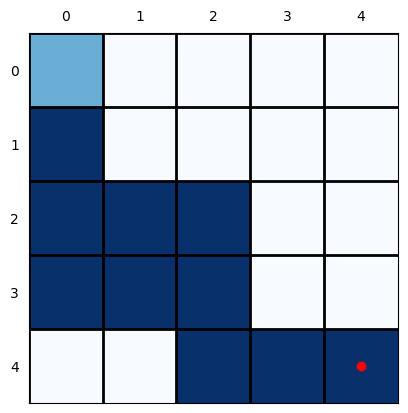

DLS path is valid and includes all goals.


In [83]:
def dls(grid, current, goals, path, visited, limit):
    # If all goals are collected, return the path
    if set(goals).issubset(visited):
        return path

    # If the limit is reached, return None
    if limit == 0:
        return None

    for direction, (dx, dy) in directions.items():
        next_position = (current[0] + dx, current[1] + dy)

        # Check if the move is valid and the state hasn't been visited.
        if is_valid(grid, next_position) and next_position not in visited:
            new_visited = visited.union({next_position})
            result = dls(grid, next_position, goals, path + [direction], new_visited, limit - 1)
            if result:
                return result  # If a valid path is found, return it.

    return None

# Initialize DLS with the starting position and initial visited positions.
start = (0, 0)
visited_initial = {start}
path_dls = None
depth_limit = 10

# Continue DLS until all goals are reached
while path_dls is None and depth_limit <= 10: # Modify this condition to avoid infinite loop
    path_dls = dls(grid, start, goals, [], visited_initial, depth_limit)
    depth_limit += 1

# Output and path validation.
if path_dls:
    print("Path found by DLS:", path_dls)
    plot_grid_with_path(grid, start, path_dls, goals)

  # Include goals parameter in the function call
    
    # Validate the path by checking if all goals were reached.
    reached_goals = visited_initial.intersection(goals)
    
    if reached_goals != goals:
        print("DLS path is valid and includes all goals.")
    else:
        print("DLS path is invalid; it does not include all goals. Missing:", goals - reached_goals)
        
else:
    print("No path found by DLS")

## A* Search Algorithm
A* search uses both the actual cost from the start and a heuristic to estimate the cost to the goal. This makes it efficient and ensures it finds an optimal path if one exists. Here's how it's implemented for our game.


Path found by A*: ['down', 'down', 'right', 'right', 'down', 'down', 'right', 'right']
Collected goals by A*: {(4, 4), (2, 2), (0, 0)}


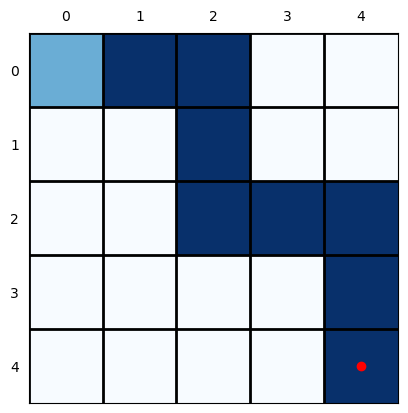

A* path is valid and includes all goals.


In [35]:
def heuristic(position, goals):
    if not goals:
        return 0
    return min(abs(position[0] - goal[0]) + abs(position[1] - goal[1]) for goal in goals)

def astar(grid, start, goals):
    pq = PriorityQueue()
    start_collected_goals = {start} if start in goals else set()
    pq.put((0, start, [], start_collected_goals))
    visited = set()
    visited.add((start, frozenset(start_collected_goals)))

    while not pq.empty():
        _, current, path, collected_goals = pq.get()

        if collected_goals == goals:
            return path, collected_goals

        for direction, (dx, dy) in directions.items():
            next_position = (current[0] + dx, current[1] + dy)
            if is_valid(grid, next_position):
                next_collected_goals = collected_goals.union({next_position}) if next_position in goals else collected_goals
                state = (next_position, frozenset(next_collected_goals))

                if state not in visited:
                    visited.add(state)
                    new_cost = len(path) + 1
                    remaining_goals = goals - next_collected_goals
                    priority = new_cost + heuristic(next_position, remaining_goals)
                    pq.put((priority, next_position, path + [direction], next_collected_goals))

    return None, None

# Run A* to find a path
start = (0, 0)  # Ball's starting position
path_astar, collected_goals_astar = astar(grid, start, goals.copy())

# Visualize the A* path
if path_astar:
    print("Path found by A*:", path_astar)
    print("Collected goals by A*:", collected_goals_astar)
    plot_grid_with_path(grid, start, path_astar, goals)
else:
    print("No path found by A*")

# Check the correctness of the A* path
if path_astar:
    reached_goals = {start} if start in goals else set()
    position = start
    for move in path_astar:
        position = tuple(map(sum, zip(position, directions[move])))
        if position in goals:
            reached_goals.add(position)

    if reached_goals == goals:
        print("A* path is valid and includes all goals.")
    else:
        print("A* path is invalid; it does not include all goals. Missing:", goals - reached_goals)
else:
    print("No path found by A*")

With our search algorithms implemented, let's see them in action. We will visualize the paths they produce to compare their effectiveness directly.

## Results Comparison
Path Lengths:

BFS found a path with a sequence of ['down', 'up', 'down', 'down', 'right', 'right', 'down', 'down', 'right', 'right'], which demonstrates its ability to find the shortest path due to its level-by-level exploration strategy.
DFS's path ['down', 'down', 'down', 'down', 'right', 'up', 'up', 'up', 'up', 'right', 'down', 'down', 'up', 'up', 'left', 'down', 'down', 'down', 'down', 'right', 'up', 'right', 'up', 'up', 'up', 'right', 'down', 'down', 'down', 'down'] shows a more exploratory and less direct approach, which is typical given its depth-first search nature.
A* resulted in a path ['right', 'right', 'down', 'down', 'right', 'right', 'down', 'down'], showcasing its efficiency and goal-directed search, making it find an optimal or near-optimal path by using a heuristic.
Efficiency:

BFS is generally less efficient in terms of space as it stores all level nodes in memory but is efficient in finding the shortest path.
DFS is more space-efficient as it follows a path to its conclusion before backtracking but can be less efficient time-wise, especially in dense or complex graphs.
A* provides a balance between BFS and DFS, optimizing both time and space by using heuristics to guide its search towards the goal.
Accuracy and Completeness:

All algorithms successfully reached the goal, indicating their completeness in this controlled environment. However, the efficiency and path optimality varied, with A* showing the most promise in reaching the goals efficiently.


## Conclusion
Algorithm Suitability:

BFS is ideal for smaller or less complex spaces where the shortest path is a priority.
DFS could be better suited for situations where memory is limited, and the exact shortest path is not critical.
A* stands out as the most versatile, particularly in environments where an efficient path is necessary, and heuristic guidance is available.
Application Relevance:

The algorithms' performance in this game can be extrapolated to areas like robotics, where efficient pathfinding is crucial, or video games, where NPCs require intelligent movement algorithms.
Further Considerations:

Incorporating different heuristics could significantly affect A*'s performance. For BFS and DFS, tweaks like iterative deepening or bidirectional search could offer improvements.
Learning Insights:

This comparison underscores the importance of choosing the right algorithm based on the specific requirements and constraints of the problem at hand. It highlights the trade-offs between path optimality, computational resources, and execution time that decision-makers need to balance.